# Analyzing Endangered Species in US National Parks - Data Science Portfolio Project

This project explores the conservation of species in National Parks. We'll look at data on the top 10 most visited US National Parks in 2022. The dataset is provided by the National Park Service via their [NPSecies Database](https://irma.nps.gov/NPSpecies/). We'll use Python to analyze the dataset and use the pandas and SciPy libraries to answer the following questions:

- How does conservation status differ across national parks?
- Are mammal species more likely to be protected than non-mammal species?
- Are native species more likely to be protected than non-native species?
- Are there any abundant species that are also classified as threatened or endangered?

### Import Libraries

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

### Load and Inspect Data

In [2]:
species = pd.read_csv('datasets/NPS_species_info.csv')
print(species.info())
species.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51706 entries, 0 to 51705
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Scientific Name      51706 non-null  object 
 1   Common Names         26107 non-null  object 
 2   Order                50908 non-null  object 
 3   Family               50869 non-null  object 
 4   Category             51706 non-null  object 
 5   Park Name            51706 non-null  object 
 6   Nativeness           48541 non-null  object 
 7   Abundance            38733 non-null  object 
 8   Observations         9097 non-null   float64
 9   Conservation Status  51706 non-null  object 
dtypes: float64(1), object(9)
memory usage: 3.9+ MB
None


,Scientific Name,Common Names,Order,Family,Category,Park Name,Nativeness,Abundance,Observations,Conservation Status
0,Alces alces,Moose,Artiodactyla,Cervidae,Mammal,Acadia National Park,Native,Rare,1.0,Least Concern
1,Odocoileus virginianus,"Northern White-tailed Deer, Virginia Deer, Whi...",Artiodactyla,Cervidae,Mammal,Acadia National Park,Native,Abundant,NaN,Least Concern
2,Canis latrans,"Coyote, Eastern Coyote",Carnivora,Canidae,Mammal,Acadia National Park,Non-native,Common,1.0,Species of Concern
3,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Carnivora,Canidae,Mammal,Acadia National Park,Native,NaN,NaN,Endangered
4,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Carnivora,Canidae,Mammal,Acadia National Park,Unknown,Common,NaN,Least Concern


The dataset contains 51,706 rows and 10 columns containing information about the species. It looks like all columns except  `Scientific Name`, `Category`, `Park Name`, and `Conservation Status` columns have some missing values.

Here's a quick summary of the columns:

- **Scientific Name**: the name of the species according to scientific nomenclature
- **Common Names**: common names or aliases the species is known by the general public
- **Order**: the taxonomic order the species belongs to
- **Family**: the taxonomic family the species belongs to
- **Category**: indicates the category or classification of the species, for example `Mammal`
- **Park Name**: the name of the national park the species was observed in
- **Nativeness**: indicates whether the species is native or non-native to the national park it was observed in
- **Abundance**: describes the abundance of the species in the national park it was observed in
- **Observations**: the number of observations or sightings used as evidence for the species occurrences
- **Conservation Status**: provides the conservation status of the species, for example `Endangered`

### Data Cleaning and Preparation

Before we can start answering our data questions, we'll need to clean and prepare the dataset for analysis. 

Let's start by standardizing the text in the column names and row values by removing extra whitespaces and converting all of the text to titles.

In [3]:
def clean_df_text(df):
    # clean the column name texts
    df.columns = df.columns.str.strip()

    # clean the row value texts
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].str.title()
            df[column] = df[column].str.strip()

    return df

In [4]:
# Apply text cleaning function
species = clean_df_text(species)

For this analysis, we'll take a look at the major animal species (non-insect) in the **Amphibian**, **Bird**, **Fish**, **Mammal**, and **Reptile** categories. Let's filter the dataset for species within these categories.

In [5]:
# Initial category counts
species['Category'].value_counts()

Insect                   15482
Vascular Plant           15415
Fungi                     5936
Spider/Scorpion           4846
Bird                      3161
Non-Vascular Plant        1868
Other Non-Vertebrates     1127
Chromista                 1007
Mammal                     794
Slug/Snail                 408
Fish                       370
Bacteria                   342
Protozoa                   282
Reptile                    248
Crab/Lobster/Shrimp        243
Amphibian                  177
Name: Category, dtype: int64

In [6]:
# Create Boolean masks for each of the categories we will investigate
amphibian = species['Category'] == 'Amphibian'
bird = species['Category'] == 'Bird'
fish = species['Category'] == 'Fish'
mammals = species['Category'] == 'Mammal'
reptile = species['Category'] == 'Reptile'

# Filter the species dataframe
species = species[amphibian | bird | fish | mammals | reptile]

In [7]:
# Filtered category counts
species['Category'].value_counts()

Bird         3161
Mammal        794
Fish          370
Reptile       248
Amphibian     177
Name: Category, dtype: int64

Next, let's take a look at the `Conservation Status` of the species in our dataset.

In [8]:
species['Conservation Status'].value_counts()

Least Concern         3367
Species Of Concern    1304
Endangered              31
Threatened              29
In Recovery             19
Name: Conservation Status, dtype: int64

There are 5 categories in the `Conservation Status` column. The majority of species are of `Least Concern` (3367). The other categories represent concerned species that need to be protected: `Species Of Concern` (1304), `Endangered` (31), `Threatened` (29), and `In Recovery` (19). 

Using this information, let's create a new column `Protected` that returns `True` for species that need protection and `False` for species that are least concerning (meaning they are not at risk for extinction or at elevated risk for being endangered). 

In [9]:
species['Protected'] = species['Conservation Status'] != 'Least Concern'

Let's now drop some columns that we won't need in our analysis to answer the data questions. 

**Note**: While we won't need them for the rest of this project, these columns do provide important information that might be useful in other analyses.

In [10]:
drop_cols = ['Order', 'Family', 'Observations']
species = species.drop(drop_cols, axis=1)

Lastly, let's preview our cleaned and prepared dataset.

In [11]:
species.head()

,Scientific Name,Common Names,Category,Park Name,Nativeness,Abundance,Conservation Status,Protected
0,Alces Alces,Moose,Mammal,Acadia National Park,Native,Rare,Least Concern,False
1,Odocoileus Virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Mammal,Acadia National Park,Native,Abundant,Least Concern,False
2,Canis Latrans,"Coyote, Eastern Coyote",Mammal,Acadia National Park,Non-Native,Common,Species Of Concern,True
3,Canis Lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Mammal,Acadia National Park,Native,NaN,Endangered,True
4,Vulpes Vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Mammal,Acadia National Park,Unknown,Common,Least Concern,False


### Initial Exploration

Before we begin our analysis, let's perform some initial exploration to develop some sense and intuition about our dataset.

In [12]:
species.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4750 entries, 0 to 50339
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Scientific Name      4750 non-null   object
 1   Common Names         4726 non-null   object
 2   Category             4750 non-null   object
 3   Park Name            4750 non-null   object
 4   Nativeness           4683 non-null   object
 5   Abundance            3896 non-null   object
 6   Conservation Status  4750 non-null   object
 7   Protected            4750 non-null   bool  
dtypes: bool(1), object(7)
memory usage: 301.5+ KB


Filtering for the 5 animal species trimmed our dataset down to 4,750 rows.

Of those rows, let's count the unique number of species in our dataset.

In [13]:
species['Scientific Name'].nunique()

1557

Interestingly, it looks like there are just 1,557 unique species of the 6,137 rows in our dataset. 

Our intitial intuition says this makes sense because there are many species that can live across multiple national parks. Let's investigate one species to see if this is the case.

In [14]:
species[species['Scientific Name']=='Canis Lupus']

,Scientific Name,Common Names,Category,Park Name,Nativeness,Abundance,Conservation Status,Protected
3,Canis Lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Mammal,Acadia National Park,Native,NaN,Endangered,True
1719,Canis Lupus,Gray Wolf,Mammal,Glacier National Park,Native,Rare,Least Concern,False
6984,Canis Lupus,Gray Wolf,Mammal,Great Smoky Mountains National Park,Native,NaN,Endangered,True
35726,Canis Lupus,"Gray Wolf, Wolf",Mammal,Grand Teton National Park,Native,Uncommon,Endangered,True
37967,Canis Lupus,"Gray Wolf, Wolf",Mammal,Indiana Dunes National Park,Native,NaN,Endangered,True
40455,Canis Lupus,Gray Wolf,Mammal,Rocky Mountain National Park,Native,NaN,Endangered,True
43656,Canis Lupus,"Gray Wolf, Wolf",Mammal,Yellowstone National Park,Native,Common,Least Concern,False
47826,Canis Lupus,"Gray Wolf, Wolf",Mammal,Yosemite National Park,Unknown,NaN,Endangered,True


It looks like the gray wolf (with scientific name *Canis Lupus*) can be spotted in 8 US national parks. However, it looks like their `Abundance`, `Conservation Status`, and `Protected` status vary from park to park which can be trickier to analyze. 

Let's now look at the number of species per `Category` in terms of both counts and percentages.

In [15]:
print(species['Category'].value_counts())
print()
print(species['Category'].value_counts(normalize=True))

Bird         3161
Mammal        794
Fish          370
Reptile       248
Amphibian     177
Name: Category, dtype: int64

Bird         0.665474
Mammal       0.167158
Fish         0.077895
Reptile      0.052211
Amphibian    0.037263
Name: Category, dtype: float64


It looks like the majority of species in our dataset are birds (66.5%) followed by mammals (16.7%), fishes (7.8%), reptiles (5.2%), and amphibians (3.7%). However, these number are biased because of the number of duplications due to species living in multiple national parks. 

Let's instead count the number of unique species by `Category`.

    Category  Scientific Name   Percent
0  Amphibian              124  0.079640
1       Bird              747  0.479769
2       Fish              231  0.148362
3     Mammal              276  0.177264
4    Reptile              179  0.114965


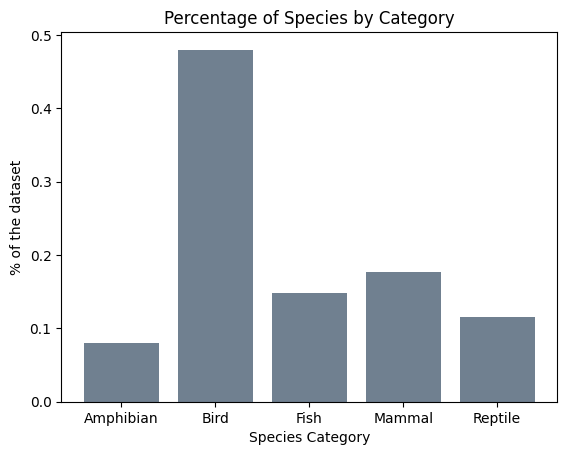

In [16]:
unique_category_counts = species.groupby('Category').agg({'Scientific Name':'nunique'}).reset_index()
unique_category_counts['Percent'] = unique_category_counts['Scientific Name'] / species['Scientific Name'].nunique()
print(unique_category_counts)

plt.bar(unique_category_counts['Category'], unique_category_counts['Percent'], color='slategray')
plt.title("Percentage of Species by Category")
plt.xlabel("Species Category")
plt.ylabel("% of the dataset")
plt.show()

Interestingly, it looks like the distribution does change when we account for duplicates, but the majority of species in our dataset are again birds (48.0%) followed by mammals (17.7%), fishes (14.8%), reptiles (11.5%), and amphibians (8.0%)

Let's do the same for `Conservation Status`.

In [17]:
print(species['Conservation Status'].value_counts())
print()
print(species['Conservation Status'].value_counts(normalize=True))

Least Concern         3367
Species Of Concern    1304
Endangered              31
Threatened              29
In Recovery             19
Name: Conservation Status, dtype: int64

Least Concern         0.708842
Species Of Concern    0.274526
Endangered            0.006526
Threatened            0.006105
In Recovery           0.004000
Name: Conservation Status, dtype: float64


Again, species that appear more than once in the dataset may be skewing the counts so let's attempt to analyze conservation status based on unique species. Recall, a species' `Conservation Status` and `Protected` status *might* vary from park to park so let's choose each species' most common status using the **mode** aggregation function. 

That said, let's also maintain information on how often a species is protected by reporting the number of `True` values in the `Protected` column.

In [18]:
unique_status = species.groupby(['Scientific Name', 'Category'])\
                       .agg({'Conservation Status':pd.Series.mode,'Protected':'sum'})\
                       .reset_index()

unique_status = unique_status.rename({'Protected':'Protected Anywhere'},axis=1)
print(unique_status['Conservation Status'].value_counts())
print()
print(unique_status['Conservation Status'].value_counts(normalize=True))

Least Concern                  1220
Species Of Concern              295
Endangered                       21
Threatened                       16
In Recovery                       4
[Endangered, Least Concern]       1
Name: Conservation Status, dtype: int64

Least Concern                  0.783558
Species Of Concern             0.189467
Endangered                     0.013487
Threatened                     0.010276
In Recovery                    0.002569
[Endangered, Least Concern]    0.000642
Name: Conservation Status, dtype: float64


Fortunately, it looks like the majority of the species are classified as Least Concern (1220 or 78.4%), meaning that most of the species are not at risk for extinction. Of course, some of these species may still be at risk in some parks, due to the mode aggregations, but these results reflect their status across all parks in our dataset. 

There are a large number of species that are classifed as Species of Concern (295 or 18.9%) meaning that they are facing serious risks of being threatened or endangered. There is also one species whose mode reflects a tie: `Endangered` and `Least Concern` in the same number of parks.

Let's do a deeper analysis and take a look at the number of unique species for each `Category` by `Conservation Status` as well.

In [19]:
unique_status['Conservation Status'] = unique_status['Conservation Status'].astype(str)

status_by_category = unique_status.pivot_table(index='Category', 
                                                   columns='Conservation Status',
                                                   values='Scientific Name', 
                                                   aggfunc='count')

# drop the one species without a unique mode
status_by_category = status_by_category.drop("['Endangered' 'Least Concern']", axis=1)

status_by_category

Conservation Status,Endangered,In Recovery,Least Concern,Species Of Concern,Threatened
Category,,,,,
Amphibian,2.0,NaN,117.0,3.0,2.0
Bird,4.0,4.0,495.0,241.0,2.0
Fish,7.0,NaN,209.0,8.0,7.0
Mammal,8.0,NaN,237.0,29.0,2.0
Reptile,NaN,NaN,162.0,14.0,3.0


 Let's visualize the number of endangered species by category.

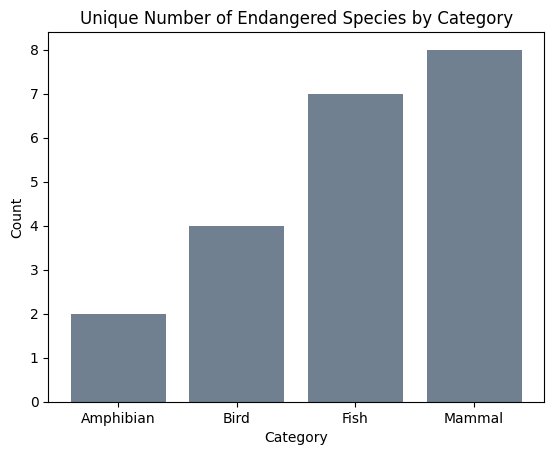

In [20]:
plt.bar(status_by_category.index, status_by_category["Endangered"], label="Endangered", color='slategray')
plt.title("Unique Number of Endangered Species by Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

Interestingly, although bird species make up about 48.0% of unique species in our dataset, there are more endangered mammals (8) than endangered birds (4). Recall mammals make up 17.7% of the unique species in our dataset! This initial exploration might be key to help answer one of our data questions asking if mammals are more favorited than non-mammals in their protective status. 

However, remember that all of this analysis is reporting aggregate status via the most common status for a species across all parks in the dataset. So let's also take a look at the `Protected` column, which we created to report the number of parks where each species is of concern.

In [21]:
# For each category, what is the total number of species+parks with a protected status?
unique_status.groupby('Category').agg({'Protected Anywhere':'sum'})

,Protected Anywhere
Category,
Amphibian,7
Bird,1187
Fish,31
Mammal,130
Reptile,28


Note that while reptiles only had 17 protected species in our mode aggregation, there are 28 instances where a reptile species is protected in some park, even if many of them are of least concern in the majority of parks.

Finally, let's take a quick look at protected and un-protected species using the mode aggregation.

In [22]:
# Re-create Protected column
unique_status['Protected'] = unique_status['Conservation Status'] != 'Least Concern'

print(unique_status['Protected'].value_counts())
print()
print(unique_status['Protected'].value_counts(normalize=True))

False    1220
True      337
Name: Protected, dtype: int64

False    0.783558
True     0.216442
Name: Protected, dtype: float64


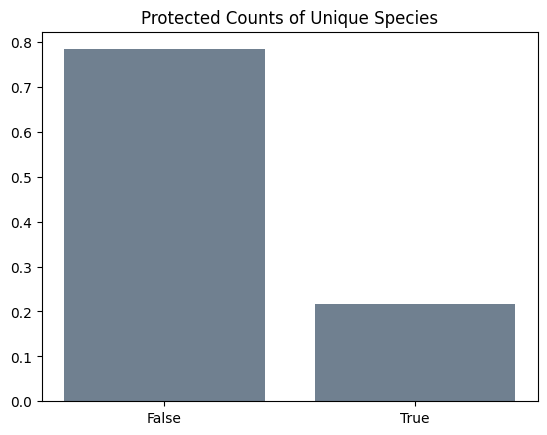

In [23]:
# Visualize protected counts
protected_counts = unique_status['Protected'].astype(int).value_counts(normalize=True)
plt.bar(protected_counts.index, protected_counts, color='slategray')
plt.title("Protected Counts of Unique Species")
plt.xticks(protected_counts.index, ['False', 'True'])
plt.show()

Looking at the protection numbers, we see that that 1220 (or 78.4%) unique species in our dataset are not protected compared to 337 (or 21.6%) unique species that are protected. 

### Data Question #1: How does conservation status differ across national parks?

Each national park boasts unique species that have adapted to their specific habitat and natural ecoystems. The impacts of changing climate as well as invasive species can cause these species to become endangered. Let's take a look at how conservation status changes across the different parks in our dataset.

Let's first take a look at the different national parks in our dataset. 

In [24]:
species['Park Name'].value_counts()

Grand Canyon National Park             683
Great Smoky Mountains National Park    633
Indiana Dunes National Park            542
Acadia National Park                   483
Yellowstone National Park              443
Zion National Park                     433
Yosemite National Park                 403
Glacier National Park                  383
Grand Teton National Park              374
Rocky Mountain National Park           373
Name: Park Name, dtype: int64

We see that the species in our dataset come from 10 different national parks. If you're knowledgeable in national parks, you may notice that these are the most visited annually in the US!

For each national park, let's count the number of species belonging in each `Conservation Status`.

In [25]:
status_by_park = species.pivot_table(index='Park Name', 
                                            columns='Conservation Status', 
                                            values='Scientific Name',
                                            aggfunc = 'count')

status_by_park.columns = ['Endangered','In Recovery','Least Concern','Species of Concern','Threatened']
status_by_park = status_by_park.reset_index()
status_by_park

,Park Name,Endangered,In Recovery,Least Concern,Species of Concern,Threatened
0,Acadia National Park,3.0,2.0,330.0,148.0,NaN
1,Glacier National Park,NaN,1.0,271.0,108.0,3.0
2,Grand Canyon National Park,5.0,3.0,496.0,173.0,6.0
3,Grand Teton National Park,1.0,2.0,256.0,113.0,2.0
4,Great Smoky Mountains National Park,9.0,1.0,505.0,115.0,3.0
5,Indiana Dunes National Park,4.0,4.0,389.0,144.0,1.0
6,Rocky Mountain National Park,1.0,1.0,259.0,109.0,3.0
7,Yellowstone National Park,1.0,2.0,299.0,137.0,4.0
8,Yosemite National Park,5.0,2.0,273.0,119.0,4.0
9,Zion National Park,2.0,1.0,289.0,138.0,3.0


Interestingly, we see that Glacier National Park has no species that are currently endangered in this dataset. 

Let's use a visualization to compare the number of endangered species by national park. 

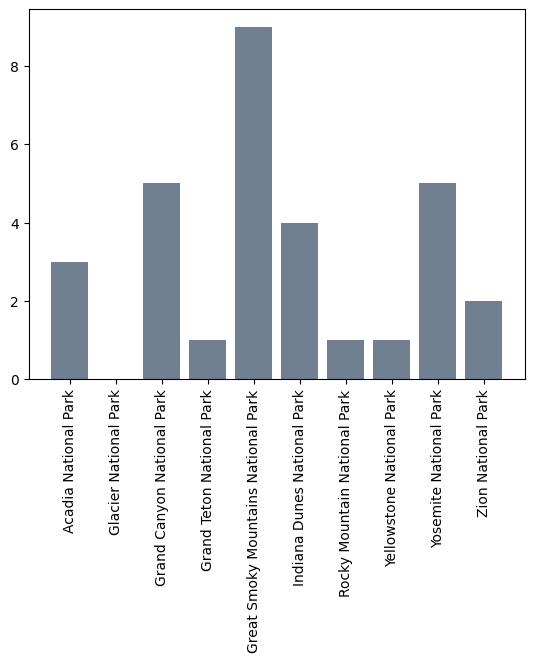

In [26]:
plt.bar(status_by_park['Park Name'], status_by_park['Endangered'], color='slategray')
plt.tick_params(axis='x', labelrotation=90)
plt.show()

Interestingly, we see that the Great Smoky Mountains National Park has the most endangered species (9), followed by the Grand Canyon and Yosemite National Parks (5), the Indiana Dunes National Park (4), Acadia National Park (3), Zion National Park (2), and lastly the Grand Teton, Rocky Mountain, and Yellowstone National Parks (1). Again, Glacier National Park has no endangered species in our dataset. 

Let's now take a look at the percent of species that are protected in each national park. Recall, protected species are endangered, recovering, concerned, or threatened.

In [27]:
protected_by_park = species.groupby('Park Name').agg({'Protected': ['sum', 'mean']}).reset_index()
protected_by_park.columns = ['Park Name', 'Count Protected', 'Percent Protected']
protected_by_park

,Park Name,Count Protected,Percent Protected
0,Acadia National Park,153,0.316770
1,Glacier National Park,112,0.292428
2,Grand Canyon National Park,187,0.273792
3,Grand Teton National Park,118,0.315508
4,Great Smoky Mountains National Park,128,0.202212
5,Indiana Dunes National Park,153,0.282288
6,Rocky Mountain National Park,114,0.305630
7,Yellowstone National Park,144,0.325056
8,Yosemite National Park,130,0.322581
9,Zion National Park,144,0.332564


Again, let's use a visualization to compare the percentage of protected species by national park.

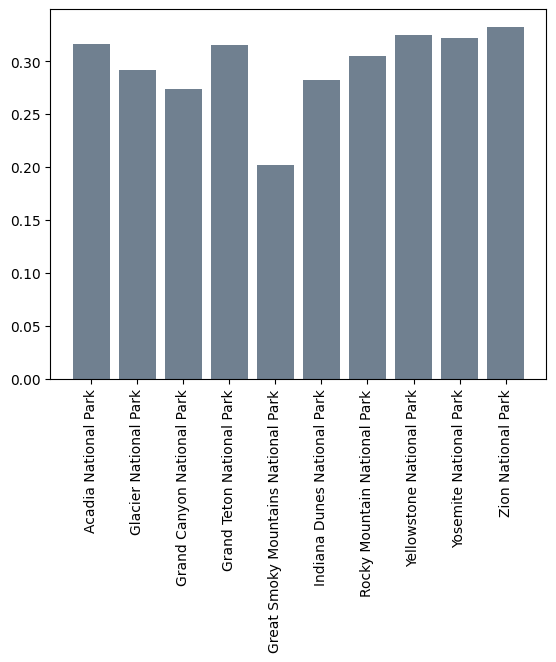

In [28]:
plt.bar(protected_by_park['Park Name'], protected_by_park['Percent Protected'], color='slategray')
plt.tick_params(axis='x', labelrotation=90)
plt.show()

In [29]:
print("Protection Statistics Across All National Parks")
print("Mean %:", np.mean(protected_by_park['Percent Protected']))
print("Std. Dev:", np.std(protected_by_park['Percent Protected']))

Protection Statistics Across All National Parks
Mean %: 0.29688286288771515
Std. Dev: 0.03643463118076456


The percentage of protected species across national parks had a mean of 29.7%. It looks like Great Smoky Mountains National Park is an outlier having the lowest percentage of protected species at 20.2% (more than 2.5x standard deviations lower!). Recall, we found that it also had the most number of endangered species as well. On the other hand, Glacier National Park had no endangered species, but has a higher percentage of protected species overall.

### Data Question #2: Are mammal species more likely to be protected than non-mammal species?

Based on the inherent connection between humans and mammals, we might expect to find a bias toward conserving mammal species over other categories.

Let's investigate the number of protected mammals and compare it to the number of protected non-mammals in our dataset. Later, we'll perform a statistical test to see if there is indeed an association between the `Category` of species and the `Protected` status.

In this case, we're interested in trends across the country. We'll use the filtered DataFrame `unique_status` containing unique species where their `Protected` and `Conservation Status` were determined by their most common status (using the mode) across all national parks in our dataset.

In [30]:
unique_status.head()

,Scientific Name,Category,Conservation Status,Protected Anywhere,Protected
0,Acanthis Flammea,Bird,Least Concern,0,False
1,Acanthus Flammea,Bird,Least Concern,0,False
2,Accipiter Cooperii,Bird,Species Of Concern,10,True
3,Accipiter Gentilis,Bird,Least Concern,0,False
4,Accipiter Striatus,Bird,Species Of Concern,10,True


In [31]:
category_counts = unique_status.pivot_table(columns='Protected',
                                      index='Category',
                                      values='Scientific Name',
                                      aggfunc='count')

category_counts.columns = ['Not Protected', 'Protected']
category_counts = category_counts.reset_index()

category_counts['Percent Protected'] = category_counts['Protected'] / \
                                        (category_counts['Protected'] + category_counts['Not Protected']) * 100

category_counts

,Category,Not Protected,Protected,Percent Protected
0,Amphibian,117,7,5.645161
1,Bird,495,252,33.734940
2,Fish,209,22,9.523810
3,Mammal,237,39,14.130435
4,Reptile,162,17,9.497207


There are some clear discrepancies based on the percentages, specifically 33.7% of birds are protected compared to the next largest group of mammals with 14.1%. 

Now, let's visualize the counts of proctected and unprotected species by category.

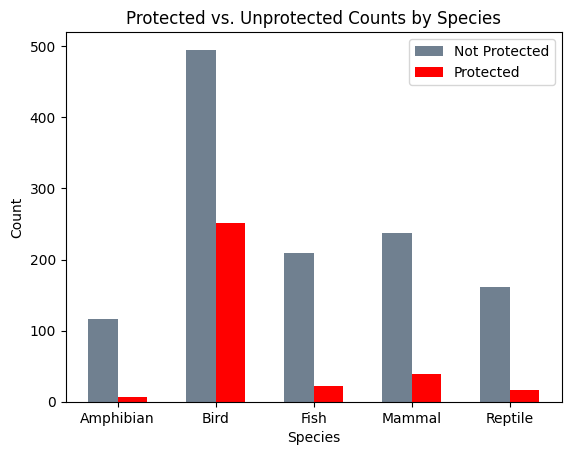

In [32]:
bar_width = 0.3
plt.bar(category_counts.index, category_counts['Not Protected'], width=bar_width, label='Not Protected', color='slategray')
plt.bar(category_counts.index + bar_width, category_counts['Protected'], width=bar_width, label='Protected', color='red')

plt.title('Protected vs. Unprotected Counts by Species')
plt.xlabel('Species')
plt.ylabel('Count')
plt.xticks(category_counts.index + bar_width / 2, category_counts['Category'].astype(str))
plt.legend()
plt.show()

It certainly appears as though there might be an association between category and protectedness. However, aside from birds as a standout category with 33% protected, it is hard to tell for sure if there's a general association.

Let's conduct a Chi-squared test using the **SciPy** library to see if there is an association between the `Category` and `Protected` variables.

We will perform a series of statistical tests. For each test, we'll use a standard significance level threshold of 0.05. In each case, our null hypothesis is that there is no association between the categories of species and protected status.

In [33]:
# import chi-squared test from SciPy library
from scipy.stats import chi2_contingency

In [34]:
# Create contingency table using pd.crosstab()
contingency_table = pd.crosstab(unique_status['Category'], unique_status['Protected'])
contingency_table

Protected,False,True
Category,,
Amphibian,117,7
Bird,495,252
Fish,209,22
Mammal,237,39
Reptile,162,17


In [35]:
# Apply chi-squared test on all categories
chi2, pval, dof, expected = chi2_contingency(contingency_table)
print("Chi-square statistic: ", chi2)
print("p-value: ", pval)

Chi-square statistic:  127.87497939202984
p-value:  1.1086552917070772e-26


The Chi-squared test comparing the protected percentages across all categories of species resulted in a test statistic of 127.87 corresponding to a p-value of 1.11e-26 (extremely low, based on our chosen threshold of .05). This leads us to reject the null hypothesis, that there is no association between category and protected status. However, this could be impacted by one particular category (birds, for example), so we'll need to investigate individual comparisons further.

In particular, let's tackle our initial data question by testing the individual associations between mammals and each non-mammal category starting with amphibians.

In [36]:
category1 = 'Mammal'
category2 = 'Amphibian'

mammal_amphibian = unique_status[(unique_status['Category']== category1) | (unique_status['Category']==category2)]
contingency_table1 = pd.crosstab(mammal_amphibian['Category'], mammal_amphibian['Protected'])
print(contingency_table1)

# Apply the chi-squared test
chi2, pvalue, dof, expected = chi2_contingency(contingency_table1)

# Print the results
print("Chi-squared test statistic:", chi2)
print("P-value:", pvalue)

Protected  False  True
Category              
Amphibian    117     7
Mammal       237    39
Chi-squared test statistic: 5.247851110300351
P-value: 0.021973891604423347


The Chi-squared test comparing the protected percentages of Mammals to Amphibians resulted in a test statistic of 5.25. This corresponds to a p-value of 0.022. This, again, leads us to reject the null hypothesis that there is no association between protected status and the categories of mammals and amphibians. In other words, statistically there is an association for these two categories and protected status.

Let's now compare the percentages of protection in Mammals to Birds.

In [37]:
category1 = 'Mammal'
category2 = 'Bird'

mammal_bird = unique_status[(unique_status['Category']== category1) | (unique_status['Category']==category2)]
contingency_table2 = pd.crosstab(mammal_bird['Category'], mammal_bird['Protected'])
print(contingency_table2)

# Apply the chi-squared test
chi2, pvalue, dof, expected = chi2_contingency(contingency_table2)

# Print the results
print("Chi-squared test statistic:", chi2)
print("P-value:", pvalue)

Protected  False  True
Category              
Bird         495   252
Mammal       237    39
Chi-squared test statistic: 37.0980365208338
P-value: 1.1233678131046551e-09


The Chi-squared test comparing the protected percentages of Mammals to Birds resulted in a test statistic of 37.10. This corresponds to a p-value of 1.12e-09 (extremely small!) Looking at the percentages, we see that 33.7% of Birds are protected compared to 14.1% of Mammals. Based on our Chi-squared test, we might conclude that there is a statistical association between protectedness and the categories Bird and Mammal.

Next, let's compare the percentages of protection in Mammals to Fish.

In [38]:
category1 = 'Mammal'
category2 = 'Fish'

mammal_fish = unique_status[(unique_status['Category']== category1) | (unique_status['Category']==category2)]
contingency_table3 = pd.crosstab(mammal_fish['Category'], mammal_fish['Protected'])
print(contingency_table3)

# Apply the chi-squared test
chi2, pvalue, dof, expected = chi2_contingency(contingency_table3)

# Print the results
print("Chi-squared test statistic:", chi2)
print("P-value:", pvalue)

Protected  False  True
Category              
Fish         209    22
Mammal       237    39
Chi-squared test statistic: 2.1048706038559013
P-value: 0.146830763509396


The Chi-squared test comparing the protected percentages of Mammals to Fish resulted in a test statistic of 2.10. This corresponds to a p-value of 0.15 which is larger than our threshold of .05, meaning we cannot reject the null hypothesis (that there is no association.)

Lastly, let's compare the percentages of protection in Mammals to Reptiles.

In [39]:
category1 = 'Mammal'
category2 = 'Reptile'

mammal_reptile = unique_status[(unique_status['Category']== category1) | (unique_status['Category']==category2)]
contingency_table4 = pd.crosstab(mammal_reptile['Category'], mammal_reptile['Protected'])
print(contingency_table4)

# Apply the chi-squared test
chi2, pvalue, dof, expected = chi2_contingency(contingency_table4)
                                               
# Print the results
print("Chi-squared test statistic:", chi2)
print("P-value:", pvalue)

Protected  False  True
Category              
Mammal       237    39
Reptile      162    17
Chi-squared test statistic: 1.7516810801419596
P-value: 0.18566553668410238


The Chi-squared test comparing the protected percentages of Mammals to Reptiles resulted in a test statistic of 1.75. This corresponds to a p-value of 0.19 which is also *not significant* meaning we cannot reject the null hypothesis (that there is no association).

When looking at the results of statistical tests comparing the percentages of protection between Mammals and Non-Mammals, there doesn't seem to be a consistent bias favoring Mammals over Non-Mammals in terms of their protection status. Compared directly to other species, sometimes there is an association and sometimes there isn't, and when there is Mammals are not consistently favored.

### Data Question #3: Are native species more likely to be protected than non-native species?

Next, let's investigate another potential bias and see if protection statuses favor native species over non-native species. 

Native species are species that have existed and co-evolved with their native natural ecosystems along with other native species. Non-native species are often referred to as alien or invasive species that have been introduced non-organically by humans or other significant events.


First, let's count the number of native and non-native species using the information in the `Nativeness` column.

In [40]:
print(species['Nativeness'].value_counts())
print()
print(species['Nativeness'].value_counts(normalize=True))

Native        4138
Non-Native     352
Unknown        193
Name: Nativeness, dtype: int64

Native        0.883622
Non-Native    0.075165
Unknown       0.041213
Name: Nativeness, dtype: float64


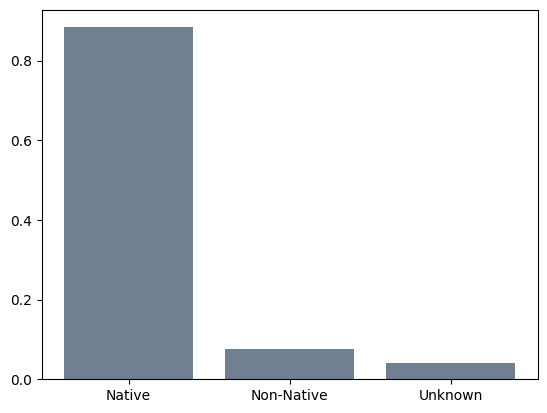

Native        88.362161
Non-Native     7.516549
Unknown        4.121290
Name: Nativeness, dtype: float64

In [41]:
nativeness_counts = species['Nativeness'].value_counts(normalize=True)
plt.bar(nativeness_counts.index, nativeness_counts.values, color='slategray')
plt.show()

nativeness_counts * 100

The vast majority (88.36%) of the species in our dataset are native while 7.52% are non-native (and the rest are unknown). This makes sense, since non-native species have to travel or be carried to a new location.

Now, let's count the number of protected and unprotected species for native and non-native species. We'll also calculate the percentages of protection for each group.

**Note:** We won't be using the aggregated counts since we some species might be native to some parks and non-native in others. 

In [42]:
nativeness_protected_counts = species.pivot_table(columns='Protected',
                                      index='Nativeness',
                                      values='Scientific Name',
                                      aggfunc='count')

nativeness_protected_counts.columns = [ 'Not Protected', 'Protected']
nativeness_protected_counts = nativeness_protected_counts.reset_index()

nativeness_protected_counts['Percent Protected'] = nativeness_protected_counts['Protected'] / \
                                        (nativeness_protected_counts['Protected'] + \
                                         nativeness_protected_counts['Not Protected']) * 100

nativeness_protected_counts

,Nativeness,Not Protected,Protected,Percent Protected
0,Native,2875,1263,30.521991
1,Non-Native,290,62,17.613636
2,Unknown,144,49,25.388601


There is a much higher number of native species than non-native species in our dataset (4138 vs. 352) and that native species also have a much higher rate of being protected (30.52% vs. 17.61%).

Let's run a Chi-squared test to see if this difference is significant.

In [43]:
category1 = 'Native'
category2 = 'Non-Native'

nativeness_protected_table = species[(species['Nativeness']== category1) | (species['Nativeness']==category2)]
contingency_table5 = pd.crosstab(nativeness_protected_table['Nativeness'], nativeness_protected_table['Protected'])
print(contingency_table5)

# Apply the chi-squared test
chi2, pvalue, dof, expected = chi2_contingency(contingency_table5)
                                               
# Print the results
print("Chi-squared test statistic:", chi2)
print("P-value:", pvalue)

Protected   False  True
Nativeness             
Native       2875  1263
Non-Native    290    62
Chi-squared test statistic: 25.368695667308685
P-value: 4.735405787894386e-07


The Chi-squared test resulted in a test statistic of 25.37 corresponding to a p-value of 4.74e-07. This leads us to reject the null hypothesis. In other words, this indicates that there is a statistical association between nativeness and protected status.

Based on the percentages of protection between native and non-native species and the results of our Chi-squared test, we see that there does seem to be some bias favoring the protection of native species over non-native species. This makes sense because native species are often more adapted and co-evolved with their local ecosystems while non-native species are often seen as invasive that compete with the native species. Oftentimes, non-native species need to be controlled or else the natural equilibrium of the local ecosystem might be jeopardized.

### Data Question #4: Are there any abundant species that are also classified as threatened or endangered?

Generally, we think of threatened species as being rarely encountered. But let's see if there are any species that are abundant (typically seen daily) but are also classified as being threatened or endangered. By investigating this possible phenomenon, we might be able to shed light on overlooked species and their conservation needs for protection. 

Let's first count the number of protected and unprotected species by their `Abundance` categorization (Abundant, Common, Occasional, Rare, Uncommon, Unknown). We won't use unique counts / aggregation of abundance categories, since species may vary in abundance across parks.

In [44]:
abundance_counts = species.pivot_table(columns='Protected',
                                      index='Abundance',
                                      values='Scientific Name',
                                      aggfunc='count')

abundance_counts.columns = ['Not Protected', 'Protected']
abundance_counts=abundance_counts.reset_index()

abundance_counts['Percent Protected'] = abundance_counts['Protected'] / \
                                        (abundance_counts['Protected'] + abundance_counts['Not Protected']) * 100

abundance_counts

,Abundance,Not Protected,Protected,Percent Protected
0,Abundant,173,37,17.619048
1,Common,973,306,23.924941
2,Occasional,319,189,37.204724
3,Rare,421,238,36.115326
4,Uncommon,648,276,29.870130
5,Unknown,244,72,22.784810


As expected, we see that the percentage of protection of `Abundant` and `Common` species are the lowest (17.62% and 23.92%), and the highest in `Occasional` and `Rare` species (37.20% and 36.12%).

Within these protected and abundant species, let's see if any of the species are also threatened or endangered.

In [45]:
abundant = species['Abundance'] == 'Abundant'
protected = (species['Conservation Status'] == 'Threatened') | (species['Conservation Status'] == 'Endangered')
protected_abundant_species = species[abundant & protected]

protected_abundant_species

,Scientific Name,Common Names,Category,Park Name,Nativeness,Abundance,Conservation Status,Protected
44082,Oncorhynchus Mykiss,Rainbow Trout,Fish,Yellowstone National Park,Non-Native,Abundant,Threatened,True


Interestingly, we find that there is a single non-native fish species in Yellowstone National Park with the scientific name Oncorhynchus Mykiss known as the Rainbow Trout, that is abundant but is threatened. Researching information on Rainbow Trout, we find that they were actually introduced into Yellowstone for sport fishing purposes. Further research shows these non-native fish are known to outcompete native trout species for food and habitat, resulting in propositions to remove Rainbow Trout in certain areas of Yellowstone.

Hopefully this investigation sheds light into overlooked species that are seemingly abundant. By recognizing this paradox, we can better understand the complexities surrounding the conservation needs of threatened/endangered species to develop more effective conservation strategies in the future. 